# Fine-Tuning SentenceTransformer on Product Matching Data and DBSCAN


In [ ]:
# Fine-Tuning SentenceTransformer on Product Matching Data
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
drive.mount('/content/drive') #, force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
import os

### fine tunes SentenceTransformer model on matched product pairs using two different loss functions, and evaluates which captures semantic similarity between Ulta and Sephora product descriptions.

In [ ]:
# load transformed datasets
ulta_df = pd.read_excel('/content/drive/My Drive/DS 677 - Sentence Transformer/Ulta_June_2025_Transformed.xlsx')
sephora_df = pd.read_excel('/content/drive/My Drive/DS 677 - Sentence Transformer/Sephora_June_2025_Transformed.xlsx')

# Load matched Pairs
pairs_df = pd.read_excel('/content/drive/MyDrive/DS 677 - Sentence Transformer/Output Files/fused_matches (image_text first).xlsx')

# Create InputExamples
all_examples = [
    InputExample(texts=[row['Ulta'], row['Sephora']], label=float(row['Score']))
    for _, row in pairs_df.iterrows()
]


In [ ]:
# Split train and validation
from sklearn.model_selection import train_test_split
train_examples, val_examples = train_test_split(all_examples, test_size=0.1, random_state=42)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
val_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(val_examples, name="val")

# Load Pretrained SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Loss Function
train_loss = losses.CosineSimilarityLoss(model)

# Fine-Tune with Manual Validation Logging
val_scores_cosine = []
val_scores_mnr = []

epochs = 3

### train with CosineSimilarityLoss
print("\nTraining with CosineSimilarityLoss")
model_cosine = SentenceTransformer('all-MiniLM-L6-v2')
train_loss_cosine = losses.CosineSimilarityLoss(model_cosine)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model_cosine.fit(
        train_objectives=[(train_dataloader, train_loss_cosine)],
        epochs=1,
        warmup_steps=100,
        show_progress_bar=True
    )
    score = val_evaluator(model_cosine)
    val_scores_cosine.append(score['val_spearman_cosine'])


### train with MultipleNegativesRankingLoss
print("\nTraining with MultipleNegativesRankingLoss")
model_mnr = SentenceTransformer('all-MiniLM-L6-v2')
train_loss_mnr = losses.MultipleNegativesRankingLoss(model_mnr)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model_mnr.fit(
        train_objectives=[(train_dataloader, train_loss_mnr)],
        epochs=1,
        warmup_steps=100,
        show_progress_bar=True
    )
    score = val_evaluator(model_mnr)
    val_scores_mnr.append(score['val_spearman_cosine'])



Training with CosineSimilarityLoss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 1/3


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 2/3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 3/3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss



Training with MultipleNegativesRankingLoss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 1/3


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 2/3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 3/3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


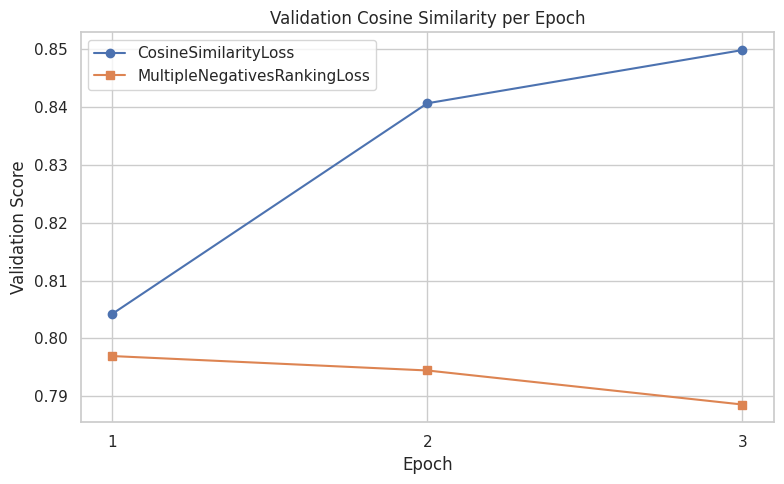

In [ ]:
'''Save the Fine-Tuned Model'''
# model_save_path = '/content/drive/My Drive/DS 677 - Sentence Transformer/fine_tuned_model'
# os.makedirs(model_save_path, exist_ok=True)
# model.save(model_save_path)
''''''


# plot Validation Scores
plt.figure(figsize=(8, 5))
epochs_range = list(range(1, epochs + 1))

plt.plot(epochs_range, val_scores_cosine, marker='o', label='CosineSimilarityLoss')
plt.plot(epochs_range, val_scores_mnr, marker='s', label='MultipleNegativesRankingLoss')

plt.title("Validation Cosine Similarity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Score")
plt.legend()
plt.grid(True)
plt.xticks(epochs_range)
plt.tight_layout()
plt.show()

### CosineSimilarityLoss vs MultipleNegativesRankingLoss

CosineSimilarityLoss outperforms MNR in terms of cosine similarity across all epochs.

cosine loss is directly optimizing for similarity, so the score reflects that.

MultipleNegativesRankingLoss is not designed to maximize similarity, but built to improve ranking performance in retrieval settings (like product search).

In [ ]:
from sentence_transformers import evaluation

# combine sephora and ulta products to build the corpus
corpus_texts = list(set(pairs_df['Sephora'].tolist() + pairs_df['Ulta'].tolist()))
corpus = {idx: text for idx, text in enumerate(corpus_texts)}
corpus_text_to_id = {text: idx for idx, text in corpus.items()}

# create queries and relevant_docs mapping
queries = {}
relevant_docs = {}

query_id = 0
for _, row in pairs_df.iterrows():
    ulta_text = row['Ulta']
    sephora_text = row['Sephora']

    if sephora_text in corpus_text_to_id and ulta_text in corpus_text_to_id:
        queries[query_id] = ulta_text  # Query is still Ulta
        relevant_docs[query_id] = [corpus_text_to_id[sephora_text]]  # Correct match is Sephora
        query_id += 1

# evaluator
ir_evaluator = evaluation.InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name='ulta-to-sephora-matching'
)


In [ ]:
from copy import deepcopy

model_mnr = deepcopy(model)  # Start with same base model

train_loss_mnr = losses.MultipleNegativesRankingLoss(model_mnr)

# Train with MNR Loss
model_mnr.fit(
    train_objectives=[(train_dataloader, train_loss_mnr)],
    epochs=3,
    warmup_steps=100,
    show_progress_bar=True
)

# Evaluate
print("Evaluation with MultipleNegativesRankingLoss:")
ir_results_mnr = ir_evaluator(model_mnr)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
500,0.323600
1000,0.177600


Evaluation with MultipleNegativesRankingLoss:


In [ ]:
print("🔹 CosineSimilarityLoss Retrieval Evaluation:")
ir_results_cosine = ir_evaluator(model_cosine)
for metric, score in ir_results_cosine.items():
    print(f"{metric}: {score:.4f}")

print("\n🔹 MultipleNegativesRankingLoss Retrieval Evaluation:")
ir_results_mnr = ir_evaluator(model_mnr)
for metric, score in ir_results_mnr.items():
    print(f"{metric}: {score:.4f}")

🔹 CosineSimilarityLoss Retrieval Evaluation:
ulta-to-sephora-matching_cosine_accuracy@1: 0.0035
ulta-to-sephora-matching_cosine_accuracy@3: 0.3495
ulta-to-sephora-matching_cosine_accuracy@5: 0.4453
ulta-to-sephora-matching_cosine_accuracy@10: 0.5312
ulta-to-sephora-matching_cosine_precision@1: 0.0035
ulta-to-sephora-matching_cosine_precision@3: 0.1165
ulta-to-sephora-matching_cosine_precision@5: 0.0891
ulta-to-sephora-matching_cosine_precision@10: 0.0531
ulta-to-sephora-matching_cosine_recall@1: 0.0035
ulta-to-sephora-matching_cosine_recall@3: 0.3495
ulta-to-sephora-matching_cosine_recall@5: 0.4453
ulta-to-sephora-matching_cosine_recall@10: 0.5312
ulta-to-sephora-matching_cosine_ndcg@10: 0.2757
ulta-to-sephora-matching_cosine_mrr@10: 0.1929
ulta-to-sephora-matching_cosine_map@100: 0.2007

🔹 MultipleNegativesRankingLoss Retrieval Evaluation:
ulta-to-sephora-matching_cosine_accuracy@1: 0.0029
ulta-to-sephora-matching_cosine_accuracy@3: 0.3585
ulta-to-sephora-matching_cosine_accuracy@5: 0

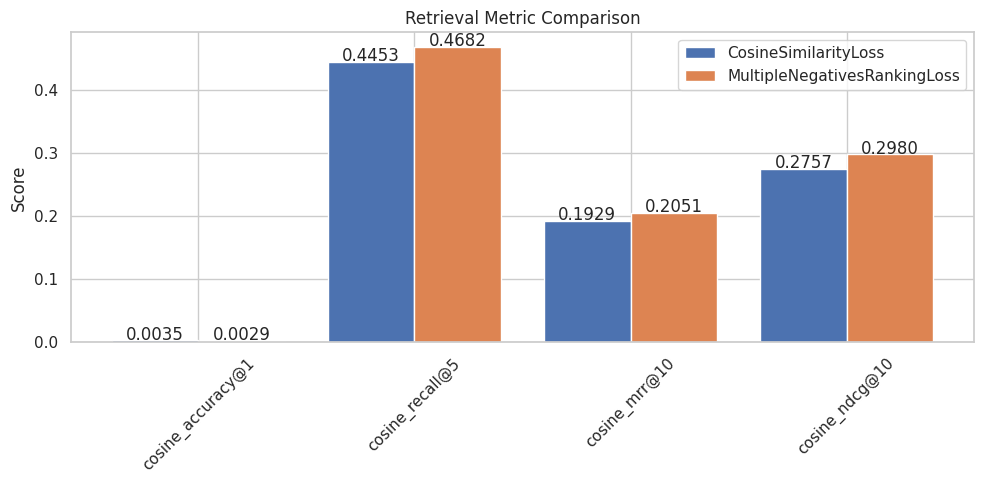

In [ ]:
import matplotlib.pyplot as plt

# Plot side-by-side bar chart for key metrics
import matplotlib.pyplot as plt

# Correct keys based on your printout
metrics_to_plot = [
    'ulta-to-sephora-matching_cosine_accuracy@1',
    'ulta-to-sephora-matching_cosine_recall@5',
    'ulta-to-sephora-matching_cosine_mrr@10',
    'ulta-to-sephora-matching_cosine_ndcg@10'
]

labels = ['CosineSimilarityLoss', 'MultipleNegativesRankingLoss']
x = range(len(metrics_to_plot))

cosine_vals = [ir_results_cosine[m] for m in metrics_to_plot]
mnr_vals = [ir_results_mnr[m] for m in metrics_to_plot]

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar([i - 0.2 for i in x], cosine_vals, width=0.4, label=labels[0])
plt.bar([i + 0.2 for i in x], mnr_vals, width=0.4, label=labels[1])
plt.xticks(ticks=x, labels=[m.replace('ulta-to-sephora-matching_', '') for m in metrics_to_plot], rotation=45)
plt.title("Retrieval Metric Comparison")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')
for i, val in enumerate(cosine_vals):
    plt.text(i - 0.2, val + 0.001, f"{val:.4f}", ha='center')

for i, val in enumerate(mnr_vals):
    plt.text(i + 0.2, val + 0.001, f"{val:.4f}", ha='center')
plt.show()


While CosineSimilarityLoss scores higher on cosine similarity, it underperforms on actual retrieval metrics.

MultipleNegativesRankingLoss (MNR) is doing what it was built for: ranking the true match higher in a list of distractors — even though it has lower cosine similarity overall.

The accuracy@1 is low for both:

- Many product pairs are very close in meaning
- The model may be choosing a correct brand but wrong variant.
- Product matching is a very fine-grained task, not just category-level.



# Clustering with DBSCAN and UMAP

I realized that fused_matches_v2 performed 1:1 matching between Sephora and Ulta products so DBSCAN is optional, but it can be benefical to understand product types/clusters

can be good for finding relevant, related, or similar products

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Get embeddings for all products
texts = pairs_df['Ulta'].tolist() + pairs_df['Sephora'].tolist()
embeddings = model.encode(texts, convert_to_numpy=True, batch_size=32)

# Cosine distances in DBSCAN
distance_matrix = cosine_distances(embeddings, embeddings)
clustering = DBSCAN(eps=0.2, min_samples=3, metric='precomputed')
cluster_labels = clustering.fit_predict(distance_matrix)

# attach labels back to the data
import pandas as pd
clustered_df = pd.DataFrame({'product': texts, 'cluster': cluster_labels})


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
!pip install umap-learn

In [ ]:
# Save MNR model
model_mnr.save('/content/drive/MyDrive/model_mnr')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/tmp/ipython-input-3946038854

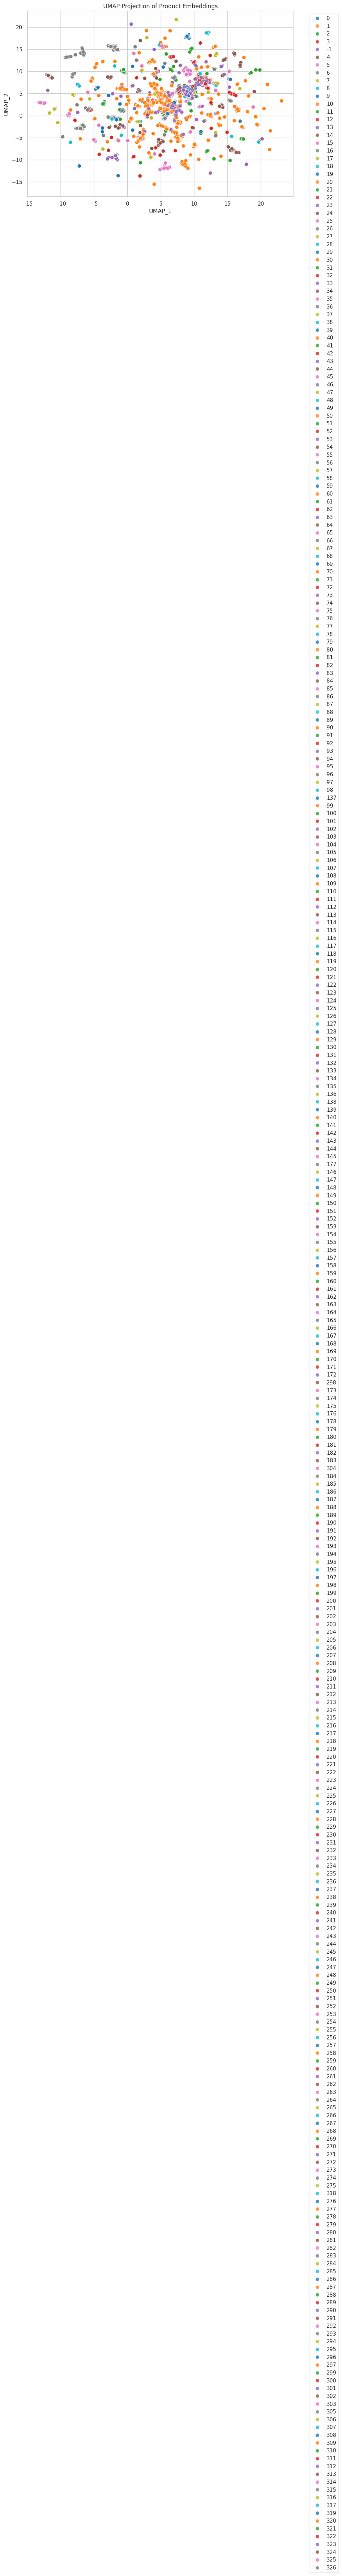

In [ ]:
import umap
from sklearn.cluster import DBSCAN

# Combine product text (Ulta + Sephora)
texts = pairs_df['Ulta'].tolist() + pairs_df['Sephora'].tolist()

# generate embeddings
model = SentenceTransformer('/content/drive/MyDrive/model_mnr')
# can also use: model = SentenceTransformer('all-MiniLM-L6-v2')
# mnr produced more differentiated clusters than base

embeddings = model.encode(texts, convert_to_numpy=True, batch_size=32)

# cluster using DBSCAN (you can try other clustering too)
from sklearn.metrics.pairwise import cosine_distances
distances = cosine_distances(embeddings)
dbscan = DBSCAN(eps=0.3, min_samples=3, metric='precomputed')
cluster_labels = dbscan.fit_predict(distances)

# UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = umap_model.fit_transform(embeddings)

# DF for plotting
df_plot = pd.DataFrame({
    'UMAP_1': embedding_2d[:, 0],
    'UMAP_2': embedding_2d[:, 1],
    'Text': texts,
    'Cluster': cluster_labels.astype(str)  # Convert to string for color mapping
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='tab10', s=60, alpha=0.8)
plt.title('UMAP Projection of Product Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
df_plot[df_plot['Cluster'] == '55'][['Text']].head(10)


,Text
632,Bumble and bumble|dont blow it fine airdry hai...
633,Bumble and bumble|travel size heat shield ther...
634,Bumble and bumble|heat shield thermal protecti...
635,Bumble and bumble|bondbuilding repair hair oil...
636,Bumble and bumble|pratapowder post workout dry...
637,Bumble and bumble|bondbuilding repair shampoo|...
638,Bumble and bumble|bondbuilding repair shampoo|...
639,Bumble and bumble|bondbuilding repair conditio...
640,Bumble and bumble|bondbuilding repair conditio...
641,Bumble and bumble|bondbuilding repair hair oil...


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Track source for matching
df_plot['Source'] = ['Ulta'] * len(pairs_df) + ['Sephora'] * len(pairs_df)

# 2. Re-attach embeddings for matching
df_plot['Embedding'] = list(embeddings)

# 3. Prepare a place to store top matches
cluster_matches = []

# 4. For each cluster, match Ulta to Sephora
for cluster_id in df_plot['Cluster'].unique():
    cluster_data = df_plot[df_plot['Cluster'] == str(cluster_id)]

    ulta_df = cluster_data[cluster_data['Source'] == 'Ulta']
    sephora_df = cluster_data[cluster_data['Source'] == 'Sephora']

    if len(ulta_df) == 0 or len(sephora_df) == 0:
        continue  # No pairs to match

    ulta_embeds = np.vstack(ulta_df['Embedding'].values)
    sephora_embeds = np.vstack(sephora_df['Embedding'].values)

    sims = cosine_similarity(ulta_embeds, sephora_embeds)

    for idx, (_, ulta_row) in enumerate(ulta_df.iterrows()):
      best_idx = np.argmax(sims[idx])
      best_match = sephora_df.iloc[best_idx]
      similarity_score = sims[idx][best_idx]

      cluster_matches.append({
          'Ulta': ulta_row['Text'],
          'Sephora': best_match['Text'],
          'Cluster': cluster_id,
          'Similarity': similarity_score
    })

# 5. Convert to DataFrame
matches_df = pd.DataFrame(cluster_matches)


In [ ]:
matches_df.sort_values(by='Similarity', ascending=False).head(10)


,Ulta,Sephora,Cluster,Similarity
555,Laura Mercier|velour puff|None|nan|nan|18.0,Laura Mercier|Velour Puff|None|nan|nan|18.0,-1,1.0
422,Anastasia Beverly Hills|slanttip stainlessstee...,Anastasia Beverly Hills|SlantTip StainlessStee...,-1,1.0
1533,FENTY BEAUTY by Rihanna|fullbodied foundation ...,Fenty Beauty by Rihanna|FullBodied Foundation ...,10,1.0
509,Grande Cosmetics|grandelashlift heated lash cu...,Grande Cosmetics|GrandeLASHLIFT Heated Lash Cu...,-1,1.0
6055,ghd|original styler 1 flat iron|None|nan|nan|...,ghd|Original Styler 1 Flat Iron|None|nan|nan|...,262,1.0
4514,Yves Saint Laurent|mens mini cologne duo set|N...,Yves Saint Laurent|Mens Mini Cologne Duo Set|N...,125,1.0
2777,ghd|glide smoothing hot brush|None|nan|nan|209.0,ghd|Glide Smoothing Hot Brush|None|nan|nan|209.0,10,1.0
6050,ghd|classic wave oval curling wand|None|nan|na...,ghd|Classic Wave Oval Curling Wand|None|nan|n...,262,1.0
2781,ghd|glide smoothing hot brush|None|nan|nan|209.0,ghd|Glide Smoothing Hot Brush|None|nan|nan|209.0,10,1.0
2779,ghd|glide smoothing hot brush|None|nan|nan|209.0,ghd|Glide Smoothing Hot Brush|None|nan|nan|209.0,10,1.0


/tmp/ipython-input-3609888923.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['Cluster'] = df_top['Cluster'].astype(str)


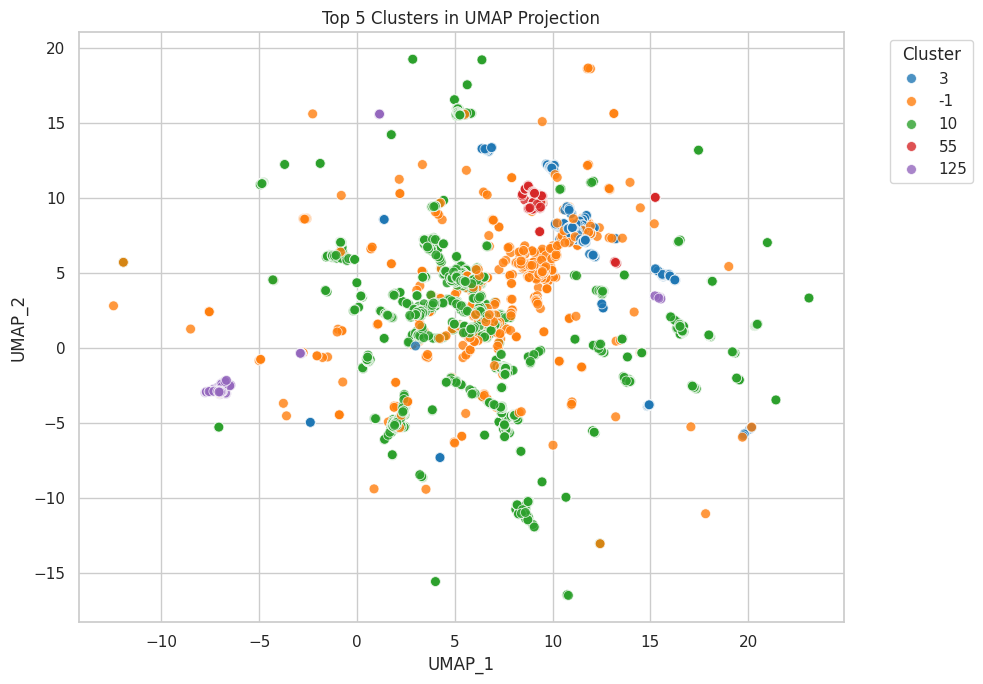

In [ ]:
from collections import Counter

# count cluster sizes
cluster_counts = Counter(df_plot['Cluster'])
top_clusters = [cluster for cluster, _ in cluster_counts.most_common(5)]

# Filter to top clusters only
df_top = df_plot[df_plot['Cluster'].isin(top_clusters)]

# Cluster label column string for consistent coloring
df_top['Cluster'] = df_top['Cluster'].astype(str)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_top,
    x='UMAP_1',
    y='UMAP_2',
    hue='Cluster',
    palette='tab10',
    alpha=0.8,
    s=50
)
plt.title("Top 5 Clusters in UMAP Projection")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
